## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.preprocessing import Imputer
%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')
sns.set()

### Descargar datos de 
https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set/data

### Funciones de utilidad


In [2]:
# Plotea histograma de datos
# función tomada de https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
def bar(acumm_data):
    # Do plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax = sns.barplot(x=acumm_data.index, y=acumm_data.values, palette='tab20b', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    
    return ax

#Plotea la matriz de confución
def print_binary_confusion_matrix(matrix):    
    TN = matrix[0,0]
    FN = matrix[1,0]
    FP = matrix[0,1]
    TP = matrix[1,1]

    print ('              +-----------------+')
    print ('              |   Predicción    |')
    print ('              +-----------------+')
    print ('              |    +   |    -   |')
    print ('+-------+-----+--------+--------+')
    print ('| Valor |  +  |  {:5d} |  {:5d} |'.format(TP, FN) )
    print ('| real  +-----+--------+--------+')
    print ('|       |  -  |  {:5d} |  {:5d} |'.format(FP, TN) )
    print ('+-------+-----+--------+--------+')

## Lectura de datos 

In [3]:
#lectura de datos
train_features_raw = pd.read_csv('Data/aps_failure_training_set.csv', na_values='na')
test_features_raw =  pd.read_csv('Data/aps_failure_test_set.csv', na_values='na')

#selecciona solo la variable a predecir
train_labels = train_features_raw['class']
test_labels = test_features_raw['class']

#selecciona solo las variables independientes
train_features = train_features_raw.drop('class', axis=1)
test_features = test_features_raw.drop('class', axis=1)

## Análisis exploratorio de datos 

In [4]:
train_features_raw['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [5]:
train_features_raw.head(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
5,neg,38312,NaN,2.130706e+09,218.0,0.0,0.0,0.0,0.0,0.0,...,388574.0,288278.0,900430.0,300412.0,1534.0,338.0,856.0,0.0,0.0,0.0
6,neg,14,0.0,6.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,168.0,48.0,60.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
7,neg,102960,NaN,2.130706e+09,116.0,0.0,0.0,0.0,0.0,0.0,...,715518.0,384948.0,915978.0,1052166.0,1108672.0,341532.0,129504.0,7832.0,0.0,0.0
8,neg,78696,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,699290.0,362510.0,1190028.0,1012704.0,160090.0,63216.0,41202.0,4.0,0.0,0.0
9,pos,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0


Se ha detectado la presencia de valores NaN

In [6]:
#Una estrategia de detección de NaN en todo el dataframe es 
#la concatenación de todos los datos en un solo arreglo y busqueda de nan
#Función inspirada en https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
flat_data = train_features.values.flatten() #conversión a arreglo en numpy
count=0 
for value in flat_data:
    if np.isnan(value) == True : #si es nan == True, se suma 1 al contador
        count=count+1;
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% de los datos no son válidos.')

8% de los datos no son válidos.


## Completando NaN

In [7]:
train_features=train_features.fillna(train_features.median())
test_features=test_features.fillna(test_features.median())

In [8]:
flat_data = train_features.values.flatten() #conversión a arreglo en numpy
count=0 
for value in flat_data:
    if np.isnan(value) == True : #si es nan == True, se suma 1 al contador
        count=count+1;
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% de los datos no son válidos.')

0% de los datos no son válidos.


Se verifica que no hay datos faltantes

### Procesando los datos de entrenamiento

In [9]:
#Reemplazo de labels de entrenamiento y prueba
train_labels = train_labels.replace({'neg':0,'pos':1});
test_labels = test_labels.replace({'neg':0,'pos':1})

### Mostrar datos desbalanceados

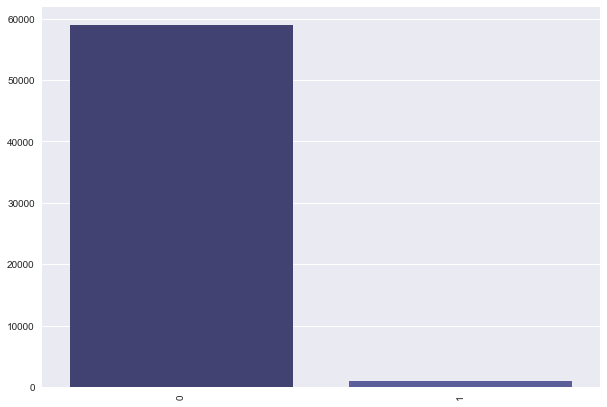

In [10]:
bar(train_labels.value_counts())
plt.show()

# Normalización
Debido a que se utilizará un clasificador de RandomForestClassifier, no se realizará ninguna transformación de datos porque se asume que este método es insensible a los tipos de datos que se utilicen

# Balanceo de datos

In [11]:
# Se selecciona una muestra class=0 con igual número de elementos de class =1
# Tomado de https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00
id_1 = train_labels[train_labels==1].index
id_0 = train_labels[train_labels==0].sample(n=1000, replace=False, random_state=0).index
id_balanced = np.concatenate((id_1,id_0)) #index de datos balanceados
#para pca
train_features_balanced = train_features.loc[id_balanced]

#labels a predecir
train_labels_balanced = train_labels.loc[id_balanced]


In [12]:
train_labels_balanced.value_counts()

1    1000
0    1000
Name: class, dtype: int64

   # Pipelines y GridSearchCV
Se utilizarán pipelines y búsqueda de grilla a fin de simplificar la cantidad de código durante la búsqueda de los mejores hiperparámetros. La referencia utilizada se encuentra en 
   
- https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/ 
- http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html

Se ha utilizado dos criterios fundamentales de reducción de dimensionalidad: PCA y SelectKBest. Se observó que en el mejor resultado publicado (https://www.kaggle.com/romulomadu/minimizing-total-cost-result-9020-00) se utilizaron distintos parámetros configurados manualmente. Se decisidió realizar una búsqueda de grilla con todos los hiperparámetros posibles.

In [13]:
#Se construye un pipeline 

selector = SelectKBest() 
classifier = RandomForestClassifier(oob_score=True)
pipeline1 = Pipeline([('select', selector), ('rfc', classifier)])
pipeline1
#Este pipeline define la secuencia de funciones por las que los datos de entrenamiento pasarán: 7
    #selección de variables, entrenamiento y predicción

Pipeline(memory=None,
     steps=[('select', SelectKBest(k=10, score_func=<function f_classif at 0x0000021E6823CD08>)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_s...timators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))])

# Definir una función score personalizada
El objetivo de la búsqueda de grilla es obtener los mejores hiperparámetros de acuerdo a un score deseado. En este caso, se creó un función de score específica de acuerdo a las necesidades del problema.

In [14]:
# Se define la función score personalizada
def score_scania(y,y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    price = (10 * fp + 500*fn) #Se introduce la formula deseada
    return price

In [15]:
 #Se utiliza la función make_scorer para crear una función invocable desde GridSearchCV
 #ver : http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
scania_price = make_scorer(score_scania, greater_is_better=True)

In [16]:
#Se definen los hiperparámetros a probar en la búsqueda de grilla
parameters = {'select__k':[92,93,95,96], 
              'select__score_func': [chi2], 
              'rfc__criterion':['gini'],
             'rfc__n_estimators':[130,140,200],
             'rfc__max_features':[7,8,'sqrt'],
             'rfc__max_depth':[100,None]};
parameters

{'rfc__criterion': ['gini'],
 'rfc__max_depth': [100, None],
 'rfc__max_features': [7, 8, 'sqrt'],
 'rfc__n_estimators': [130, 140, 200],
 'select__k': [92, 93, 95, 96],
 'select__score_func': [<function sklearn.feature_selection.univariate_selection.chi2>]}

In [17]:
#Se seleccionan los siguientes parámetros de importancia:
#scoring = 'recall'

gs_1 = GridSearchCV(pipeline1, 
                    param_grid=parameters,
                    n_jobs=4, 
                    scoring='f1',
                    verbose=40,cv=2).fit(train_features_balanced,train_labels_balanced)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 141 out of 144 | elapsed:   42.9s remaining:    0.8s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:   43.0s finished


In [18]:
#El mejor score f1 es:
gs_1.best_score_

0.9575098814229249

In [19]:
#Los mejores parámetros son:
gs_1.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__max_features': 8,
 'rfc__n_estimators': 130,
 'select__k': 93,
 'select__score_func': <function sklearn.feature_selection.univariate_selection.chi2>}

## Predicción Random Forest

In [20]:
predicted_labels=gs_1.predict(test_features)

In [21]:
#Función que calcula el costo total de acuerdo al problema
def costo_total(cm):
    costo= 10*cm[0,1] + 500*cm[1,0]
    return costo

In [22]:
cm_rf =confusion_matrix(test_labels, predicted_labels)
print_binary_confusion_matrix (cm_rf)

print('Costo total para Random forest y PCA es',costo_total(cm_rf))

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |    370 |      5 |
| real  +-----+--------+--------+
|       |  -  |    871 |  14754 |
+-------+-----+--------+--------+
Costo total para Random forest y PCA es 11210


## Experimentación con diferentes scores

In [23]:
gs_2 = GridSearchCV(pipeline1, 
                    param_grid=parameters,
                    n_jobs=4, 
                    scoring='recall',
                    verbose=40,cv=2).fit(train_features_balanced,train_labels_balanced)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 141 out of 144 | elapsed:   42.7s remaining:    0.8s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:   43.0s finished


In [24]:
predicted_labels_2=gs_2.predict(test_features)

In [25]:
cm_rf_2 =confusion_matrix(test_labels, predicted_labels)
print_binary_confusion_matrix (cm_rf_2)

print('Costo total para Random forest y PCA es',costo_total(cm_rf_2))

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |    370 |      5 |
| real  +-----+--------+--------+
|       |  -  |    871 |  14754 |
+-------+-----+--------+--------+
Costo total para Random forest y PCA es 11210


In [26]:
gs_3 = GridSearchCV(pipeline1, 
                    param_grid=parameters,
                    n_jobs=4, 
                    verbose=40,cv=2).fit(train_features_balanced,train_labels_balanced)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 141 out of 144 | elapsed:   42.4s remaining:    0.8s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:   42.6s finished


In [27]:
predicted_labels_3=gs_3.predict(test_features)

In [28]:
cm_rf_3 =confusion_matrix(test_labels, predicted_labels)
print_binary_confusion_matrix (cm_rf_3)

print('Costo total para Random forest y PCA es',costo_total(cm_rf_3))

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |    370 |      5 |
| real  +-----+--------+--------+
|       |  -  |    871 |  14754 |
+-------+-----+--------+--------+
Costo total para Random forest y PCA es 11210
